# HEAD POSE BIWI

dataset
https://s3.amazonaws.com/fast-ai-imagelocal/biwi_head_pose.tgz

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *

# Data

In [0]:
!mkdir data

In [4]:
%cd "/content/data"
! wget "https://s3.amazonaws.com/fast-ai-imagelocal/biwi_head_pose.tgz"

/content/data
--2019-12-03 14:02:49--  https://s3.amazonaws.com/fast-ai-imagelocal/biwi_head_pose.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.145.77
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.145.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 452316199 (431M) [application/x-tar]
Saving to: ‘biwi_head_pose.tgz’

biwi_head_pose.tgz  100%[===================>] 431.36M  13.5MB/s    in 33s     

2019-12-03 14:03:24 (12.9 MB/s) - ‘biwi_head_pose.tgz’ saved [452316199/452316199]



In [5]:
%ls

biwi_head_pose.tgz


In [6]:
!tar -xvzf biwi_head_pose.tgz

biwi_head_pose/
biwi_head_pose/io_sample.cpp
biwi_head_pose/06/
biwi_head_pose/06/frame_00561_pose.txt
biwi_head_pose/06/frame_00145_pose.txt
biwi_head_pose/06/frame_00491_pose.txt
biwi_head_pose/06/frame_00030_pose.txt
biwi_head_pose/06/frame_00113_rgb.jpg
biwi_head_pose/06/frame_00227_rgb.jpg
biwi_head_pose/06/frame_00054_rgb.jpg
biwi_head_pose/06/frame_00443_pose.txt
biwi_head_pose/06/frame_00031_pose.txt
biwi_head_pose/06/frame_00069_pose.txt
biwi_head_pose/06/frame_00225_rgb.jpg
biwi_head_pose/06/frame_00215_pose.txt
biwi_head_pose/06/frame_00142_rgb.jpg
biwi_head_pose/06/frame_00504_rgb.jpg
biwi_head_pose/06/frame_00116_pose.txt
biwi_head_pose/06/frame_00139_pose.txt
biwi_head_pose/06/frame_00291_rgb.jpg
biwi_head_pose/06/frame_00339_pose.txt
biwi_head_pose/06/frame_00397_rgb.jpg
biwi_head_pose/06/frame_00178_pose.txt
biwi_head_pose/06/frame_00087_pose.txt
biwi_head_pose/06/frame_00031_rgb.jpg
biwi_head_pose/06/frame_00112_rgb.jpg
biwi_head_pose/06/frame_00588_pose.txt
biwi_head_

In [0]:
path = Path('/content/data/biwi_head_pose')

In [8]:
cal = np.genfromtxt(path/'01'/'rgb.cal',skip_footer=6);cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [0]:
fname = path/'09'/'frame_00667_rgb.jpg'

In [0]:
def img2txt_name(f):return f'{str(f)[:-7]}pose.txt'

In [0]:
open_image??

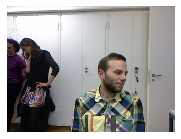

In [12]:
img = open_image(fname)
img.show()

In [13]:
ctr = np.genfromtxt(img2txt_name(fname),skip_header=3);ctr

array([187.332 ,  40.3892, 893.135 ])

In [0]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

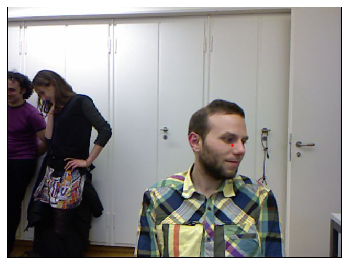

In [15]:
ctr = get_ctr(fname)
img.show(y = get_ip(img, ctr),figsize = (6,6))

## Create dataset

In [0]:
data = (
    PointsItemList.from_folder(path)
    .split_by_valid_func(lambda o: o.parent.name=='13') #validation set is just one person 
    .label_from_func(get_ctr)
    .transform(get_transforms(),tfm_y=True, size = (120, 160))
    .databunch().normalize(imagenet_stats)
)

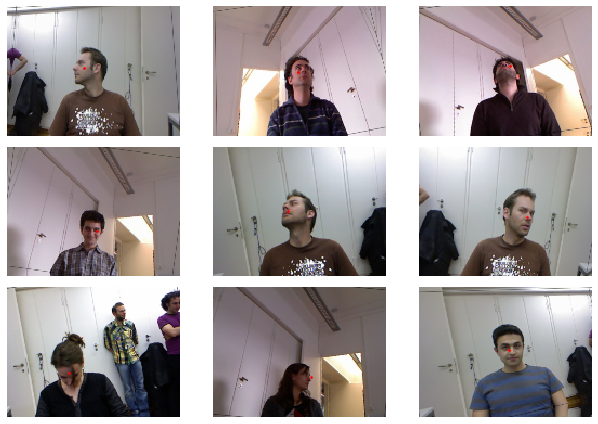

In [18]:
data.show_batch(3,figsize = (9,6))

## Model

- loss function for classification - Cross entropy loss
- loss function for regression - Mean square error


In [19]:
learn = create_cnn(data, models.resnet34)
learn.loss_func = MSELossFlat()

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 77.0MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


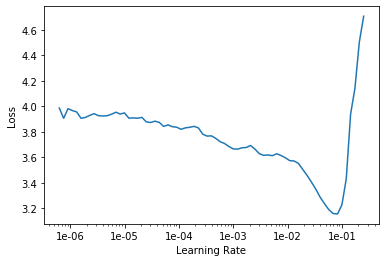

In [20]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 2e-2

In [22]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,time
0,0.127062,0.016391,02:39
1,0.042007,0.005663,02:39
2,0.014668,0.003687,02:40
3,0.008363,0.001948,02:40
4,0.006476,0.002128,02:45


In [0]:
learn.save('stage-1')

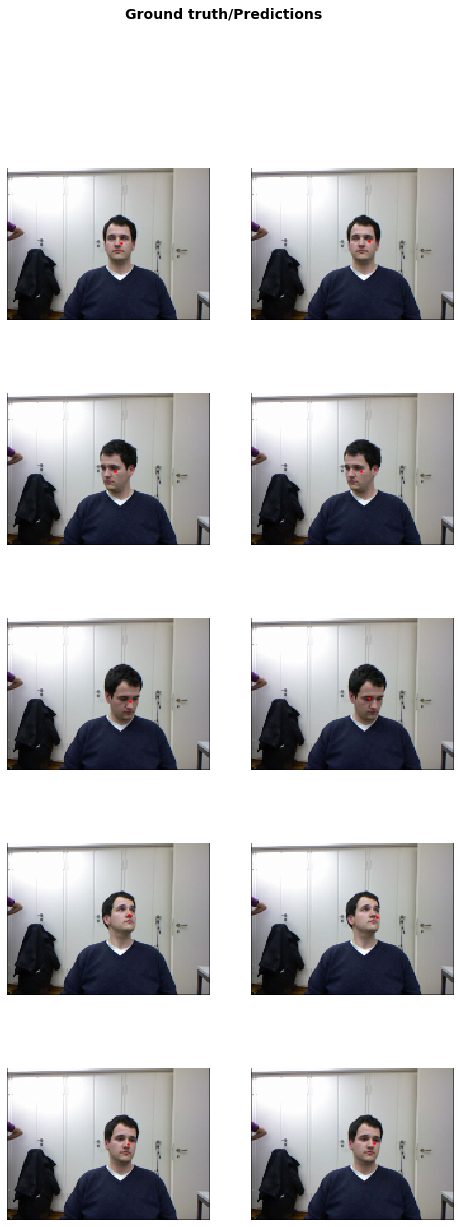

In [24]:
learn.show_results()